## 회사 URL로 정보 제공 가정
기업 -> 회사 정보를 url 형식으로 제공 가정
동적 웹 정보를 제대로 로더하지 못함 추후 셀레니움 크롤링 로직 등 보완 필요

In [6]:
import os
from dotenv import load_dotenv

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://www.koreaodm.com/about/",
    "https://www.koreaodm.com/edu-2/",
    "https://www.koreaodm.com/tech/",
    "https://www.koreaodm.com/consulting/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=80
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = FAISS.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

In [8]:
# 테스트를 위한 예시 질문
query = "회사 정보를 모두 가져와"

# 관련 문서를 검색합니다.
retrieved_docs = retriever.get_relevant_documents(query)

# 검색 결과를 확인합니다.
for idx, doc in enumerate(retrieved_docs):
    print(f"문서 {idx+1}:")
    print(doc.page_content)
    print("\n---\n")

문서 1:
회사소개 선한인공지능연구소 | 더선한(주)
HQ | 경상남도 진주시 비봉로33번길14
Lab | 서울특별시 서초구 효령로 391
사업자등록번호 | 213-07-80953
통신판매업번호 | 2019-경남진주-0253
소프트웨어사업자 | B32-208587

---

문서 2:
회사소개 선한인공지능연구소 | 더선한(주)
HQ | 경상남도 진주시 비봉로33번길14
Lab | 서울특별시 서초구 효령로 391
사업자등록번호 | 213-07-80953
통신판매업번호 | 2019-경남진주-0253
소프트웨어사업자 | B32-208587

---

문서 3:
회사소개 선한인공지능연구소 | 더선한(주)
HQ | 경상남도 진주시 비봉로33번길14
Lab | 서울특별시 서초구 효령로 391
사업자등록번호 | 213-07-80953
통신판매업번호 | 2019-경남진주-0253
소프트웨어사업자 | B32-208587

---

문서 4:
회사소개 선한인공지능연구소 | 더선한(주)
HQ | 경상남도 진주시 비봉로33번길14
Lab | 서울특별시 서초구 효령로 391
사업자등록번호 | 213-07-80953
통신판매업번호 | 2019-경남진주-0253
소프트웨어사업자 | B32-208587

---



## 회사 정보 PDF 형식으로 제공 가정

In [7]:
from typing import Annotated, Dict, List, TypedDict, Any, Optional
from langchain.document_loaders import PyPDFLoader  # PDF 파일 로더 사용
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever
from langchain_openai import OpenAIEmbeddings
from kiwipiepy import Kiwi

kiwi = Kiwi()

# kiwi 토크나이징 함수
def kiwi_tokenize(text: str) -> List[str]:
    """
    Tokenizes the input text using the Kiwi tokenizer.
    """
    tokens = kiwi.tokenize(text)
    return [token.form for token in tokens if token.tag != "SPACE"]

pdf_file = "PEAK_internship.pdf"

# PDF 문서 로드
loader = PyPDFLoader(pdf_file)
docs = loader.load()


text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=80
)
doc_splits = text_splitter.split_documents(docs)

# 3. FAISS 벡터스토어 생성 및 FAISS 리트리버 생성 (임베딩 기반 검색)
faiss_vectorstore = FAISS.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings()
)
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 5})

# 4. BM25 리트리버 생성 (토큰 기반 검색)
bm25_retriever = BM25Retriever.from_documents(
    documents=doc_splits,
    search_kwargs={"k": 5},
    tokenizer=kiwi_tokenize,
)

# 5. Ensemble 리트리버 생성: BM25와 FAISS 리트리버를 각각 0.5의 가중치로 결합
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever],
    weights=[0.5, 0.5]
)

# 6. 테스트: 특정 쿼리로 Ensemble 리트리버를 통해 검색 결과 확인
test_query = "Internship program details"
retrieved_docs = ensemble_retriever.get_relevant_documents(test_query)


In [16]:
# 검색 결과를 확인합니다.
for idx, doc in enumerate(retrieved_docs):
    print(f"문서 {idx+1}:")
    print(doc.page_content)
    print("\n---\n")

문서 1:
M e e t  f o r  D e a l  T M
. c e o da vid@goodai.kr
권태욱 대표이사
010-8536- 2267

---

문서 2:
B 2 B  세 일 즈  리 드  C D P  
유 망 고 객  추 천  알 고 리 즘  &  성 공 가 능 성  스 코 어 링  A I  R & D

---

문서 3:
S5: Series B
매출 확대 :  V a a
파트별 전문가 영
파트너사 1, 000+
S4: Scale Up
기술 고도화 sL
기업문화 정
일본 시장 성장
S3: Series A
S1: Seed 
A gent R&
S-바우처  (수요
Seed 진행
R o m a n s  8 : 2 8W o r k  f o r  t h e  g o o d
A S N S
P i o n e e r  
g e n t -
B 2 B
B 2 G
B 2 W

---

문서 4:
P R O B L E M
9 9 % 중4 / 1 0  
※  F G I  :  스 타 트 업  C E O  및   세 일 즈  담 당 자   7 , 9 6 7 명  ( 2 0 1 9 . 0 9  ~   2 0 2 5 . 1 1 )
2 천
A I  에 이 전 트 로  비 효 율  낮 추 고   매 출 증 대 를  할  수  있 지  않 을 까 ?

---

문서 5:
2026 20302029202820272025
해외진출 가속
바우처 공급 기
TIPS 수행 
S2: TIPS
1,500억+ V alu
파트너사 3, 000개 돌파
주주 지향 경영
S6: M&A 
파트너사 2, 000개 돌파
보안 강
아시아 중심 네트워크 구축
S5: Series B
매출 확대 :  V a a
파트별 전문가 영

---

문서 6:
심층정보
사업자등록증 기준 업종, 업태 및 주요 활동 지역, 
홈페이지 및 5년간 뉴스 정보 등 주요 정보를 
수집하여 자체 알고리즘으로 분석 후 
유망 고객 선별
인과추론
성향 점수 매칭 ( Pr opensity  Scor e M a tching )과

---

문서

## CSV 데이터 학습

In [8]:
import pandas as pd
from langchain.schema import Document

# CSV 파일의 처음 1000행만 로드 (테스트용)
df = pd.read_csv("company_data.csv", nrows=1000)

def row_to_text(row) -> str:
    template = (
        f"회사명: {row['company']}\n"
        f"주소: {row['address']}\n"
        f"홈페이지: {row['homepage']}\n"
        f"업종: {row['industry']}\n"
        f"주요 임원: {row['key_executive']}\n"
        f"연락처: {row['phone_number']}\n"
        f"매출: {row['sales']}\n"
    )
    return template

csv_docs = []
for idx, row in df.iterrows():
    text_content = row_to_text(row)
    doc = Document(page_content=text_content, metadata={"source": "csv", "row_index": idx})
    csv_docs.append(doc)

print(f"CSV에서 테스트용으로 추출된 회사 문서 수: {len(csv_docs)}")



CSV에서 테스트용으로 추출된 회사 문서 수: 1000


In [9]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

pdf_file = "PEAK_internship.pdf"

# 1) PDF 문서 로드
loader = PyPDFLoader(pdf_file)
pdf_docs = loader.load()

# 2) 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, 
    chunk_overlap=80
)
pdf_doc_splits = text_splitter.split_documents(pdf_docs)
print(f"PDF에서 Chunk: {len(pdf_doc_splits)}")

PDF에서 Chunk: 53


In [10]:
# CSV 텍스트 분할
csv_doc_splits = text_splitter.split_documents(csv_docs)
print(f"CSV 문서에서 추출된 조각(Chunk) 수: {len(csv_doc_splits)}")

CSV 문서에서 추출된 조각(Chunk) 수: 1022


In [11]:
# FAISS 벡터스토어 생성 및 FAISS 리트리버 생성 (임베딩 기반 검색)
all_doc_splits = pdf_doc_splits + csv_doc_splits

faiss_vectorstore = FAISS.from_documents(
    documents=all_doc_splits,
    embedding=OpenAIEmbeddings()
)


In [12]:
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k":20})

kiwi = Kiwi()
def kiwi_tokenize(text: str) -> List[str]:
    tokens = kiwi.tokenize(text)
    return [token.form for token in tokens if token.tag != "SPACE"]

bm25_retriever = BM25Retriever.from_documents(
    documents=all_doc_splits,
    search_kwargs={"k": 20},
    tokenizer=kiwi_tokenize,
)

ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever],
    weights=[0.3, 0.7]
)

test_query = "회사 정보에 부합하는 영업 대상의 리스트를 가져와"
retrieved_docs = ensemble_retriever.get_relevant_documents(test_query)

for idx, doc in enumerate(retrieved_docs):
    print(f"문서 {idx+1} (출처: {doc.metadata.get('source')}):")
    print(doc.page_content)
    print("\n---\n")

문서 1 (출처: PEAK_internship.pdf):
심층정보
사업자등록증 기준 업종, 업태 및 주요 활동 지역, 
홈페이지 및 5년간 뉴스 정보 등 주요 정보를 
수집하여 자체 알고리즘으로 분석 후 
유망 고객 선별
인과추론
성향 점수 매칭 ( Pr opensity  Scor e M a tching )과

---

문서 2 (출처: PEAK_internship.pdf):
Data Lak e
리빙 B2B2G D A T A 확보 중 
기업별 (업종업태,  위치
매출/임직원수 (규모
제품군 (제조,  정보통신 등
경쟁사,  3개년 뉴스 정
결제권자 성향,  관심 등 민감정
커뮤니케이션 빈도 & 구매주

---

문서 3 (출처: csv):
회사명: 가온데이터
주소: 서울특별시 영등포구 여의대방로69길 7 (여의도동, 충무빌딩) 607호
홈페이지: -
업종: 기타 정보기술 및 컴퓨터운영 관련 서비스업
주요 임원: 이태재
연락처: 02-825-3232
매출: -

---

문서 4 (출처: PEAK_internship.pdf):
폭 발 적 인   시 장  성 장 과  
 자 산 화  
버 티 컬  A I
1 . 1 만  관 계 망  D a t a
세 일 즈  하 이 퍼  파 라 미 터  최 적 화  
9 천 명 의  C E O ’ s
공공기관 및 기업 
Data Lak e
리빙 B2B2G D A T A 확보 중 
기업별 (업종업태,  위치

---

문서 5 (출처: csv):
회사명: 가버먼트오브싱가포르코퍼레이션피티이.엘티디.
주소: 서울특별시 종로구 내자동 세양빌딩 김&장 법률사무소
홈페이지: -
업종: 기금 운영업
주요 임원: Ho Yuit Mun
연락처: 02-3703-1114
매출: -

---

문서 6 (출처: csv):
회사명: 가온알이에스
주소: 경기도 용인시 처인구 명지로60번길 8-12 105호(역북동)
홈페이지: -
업종: 주거용 건물 개발 및 공급업
주요 임원: 방영웅
연락처: 313361162
매출: -

---

문서 7 (출처: csv

### Retrieval Grader

In [13]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

# 데이터 모델 정의: 회사 프로필이 영업 리드 기준에 부합하는지 평가
class GradeCandidateLead(BaseModel):
    binary_score: str = Field(
        description="회사의 프로필 정보가 영업 타겟 기준(예: 의사 결정권자, 연락처, 부서 정보 등)에 부합하면 'yes', 아니라면 'no'"
    )

# LLM 초기화
lead_scoring_llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_lead_grader = lead_scoring_llm.with_structured_output(GradeCandidateLead)

# 프롬프트 작성
lead_grading_system_prompt = (
    "당신은 영업 리드 스카우트 에이전트로서, 회사 프로필 정보를 평가하여 해당 회사가 영업 타겟(의사 결정권자, 부서 연락처 등) 기준에 부합하는지 판단합니다. "
    "프로필 내에 관련 정보가 충분하면 'yes', 부족하면 'no'로 평가하세요."
)
lead_grading_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", lead_grading_system_prompt),
        ("human", "회사 프로필 정보:\n\n{document}\n\n영업 리드 기준:\n\n{question}")
    ]
)

# Grader 체인 구성
retrieval_lead_grader = lead_grading_prompt | structured_lead_grader

### 영업 리드 RAG 체인

간단 구현 프롬프트 및 체인 수정 가능

In [14]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# RAG 프롬프트 불러오기 (기본)
# 참고 https://smith.langchain.com/hub/rlm/rag-prompt?organizationId=c6c9b1c2-0751-49e2-b7e7-f700a66fa3c3

base_prompt = hub.pull("rlm/rag-prompt")
additional_instructions = (
    "\n\n최종 결과에는 반드시 특정 회사명, 연락처 정보 및 구체적인 행동 계획(예: 추가 연락 또는 미팅 제안)이 포함되어야 합니다."
)
improved_rag_text = (
    "다음 회사 프로필 정보를 바탕으로 영업 리드 후보를 도출하세요. "
    "결과에는 반드시 회사명, 연락처 정보, 그리고 구체적인 행동 계획(예: 추가 연락, 미팅 제안 등)이 포함되어야 합니다. "
    "내부 정보와 최신 외부 뉴스/보도자료를 참고하여, 대상 회사의 영업 리드 적합성을 평가하세요."
)
# 영업 리드 후보 생성을 위한 LLM 초기화 (생성 모델 사용)
gen_llm = ChatOpenAI(model_name="gpt-4o", temperature=0.5)

def format_documents(docs):
    """각 Document의 page_content를 하나의 문자열로 연결합니다."""
    return "\n\n".join(doc.page_content for doc in docs)

lead_prompt = base_prompt + improved_rag_text + additional_instructions

# RAG 체인 구성: 프롬프트 → LLM → 문자열 출력 파서
lead_rag_chain = lead_prompt | gen_llm | StrOutputParser()

# 테스트
generation = lead_rag_chain.invoke({"context": retrieved_docs, "question": "영업 타겟 후보의 요약 정보를 만들어줘"})
print(generation)

회사의 프로필 정보를 기반으로 영업 리드 후보로 '가온데이터'를 추천합니다. 연락처는 02-825-3232입니다. 이 회사는 정보기술 및 컴퓨터운영 관련 서비스업에 종사하므로, IT 솔루션이나 서비스 제공을 위한 추가 연락 및 미팅 제안을 고려할 수 있습니다.


### 질문 재작성 chain 구성
초기 입력된 영업 기준 또는 검색 쿼리가 모호할 경우, 이를 보다 명확하고 구체적으로 바꿔서 검색 성능을 높입니다.

In [15]:
# 질문 재작성용 시스템 프롬프트
rewriter_system_prompt = (
    "당신은 영업 리드 검색을 위한 질문 개선을 위한 전문 에이전트입니다. "
    "입력된 영업 기준을 더 구체적이고 조건화된 질문으로 재작성해 주세요. "
    "예를 들어, 'IT 부문 구매 결정권자 및 연락처 정보' 등 구체적인 정보를 포함하도록 해 주세요."
)

rewriter_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", rewriter_system_prompt),
        ("human", "초기 영업 기준:\n\n{question}\n\n보다 구체적인 조건을 포함한 질문으로 재작성해 주세요.")
    ]
)

# 재작성 체인 구성
question_rewriter = rewriter_prompt | lead_scoring_llm | StrOutputParser()

# 테스트
improved_question = question_rewriter.invoke({"question": "영업 타겟 후보 찾아줘"})
print(improved_question)


다음과 같은 구체적인 조건을 포함하여 영업 타겟 후보를 찾아주세요:

1. **산업 분야**: IT 부문에서 활동하는 기업
2. **직책**: 구매 결정권자(예: IT 매니저, CTO, CIO)
3. **기업 규모**: 직원 수 100명 이상인 중견 기업
4. **위치**: 서울 및 수도권 지역
5. **연락처 정보**: 이메일 주소 및 직통 전화번호
6. **기술 스택**: 클라우드 솔루션을 도입한 경험이 있는 기업

이러한 조건을 충족하는 영업 타겟 후보를 추천해 주세요.


### 웹 검색 도구

In [16]:
from langchain_community.tools.tavily_search import TavilySearchResults

# 웹 검색 도구 구성: 검색 결과 3개로 제한
lead_web_search_tool = TavilySearchResults(k=3)

In [33]:
from langchain.schema import Document

def web_search(state: dict) -> dict:
    """
    웹 검색을 수행하여 추가 정보를 결합하는 단계입니다.
    개선된 질문(영업 기준 등)을 사용해서 웹 검색을 수행하고, 
    반환된 결과를 Document 객체로 만들어 기존 문서 리스트에 추가합니다.
    """
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]
    
    # 웹 검색 실행 (검색 쿼리는 개선된 질문을 그대로 사용)
    search_results = lead_web_search_tool.invoke({"query": question})
    
    # search_results가 리스트인지 문자열인지 확인하여 처리
    if isinstance(search_results, str):
        web_text = search_results
    elif isinstance(search_results, list):
        try:
            web_text = "\n".join([result["content"] for result in search_results])
        except Exception as e:
            print("웹 검색 결과 파싱 중 오류:", e)
            web_text = str(search_results)
    else:
        web_text = str(search_results)
    
    # 검색 결과를 하나의 Document로 생성, 메타데이터에 source 표시
    web_doc = Document(page_content=web_text, metadata={"source": "web"})
    
    # 기존 문서 리스트에 추가
    documents.append(web_doc)
    
    # 상태 업데이트 후 반환 (원래 state["web_search"] 그대로 사용하거나 업데이트 가능)
    return {
        "documents": documents,
        "question": question,
        "web_search": state["web_search"],
        "generation": ""
    }

# 테스트 코드 예시 (단독 실행 시):
test_state = {
    "documents": [],
    "question": "IT 부문 구매 결정권자 및 연락처 정보",
    "web_search": "No",
    "generation": ""
}
updated_state = web_search(test_state)
print(updated_state)

---WEB SEARCH---
{'documents': [Document(metadata={'source': 'web'}, page_content='기업의 마케팅 팀은 IT부서를 거치지 않고 바로 세일즈포스닷컴과 계약하고, 그것에 대한 공식 평가나 표준화 같은 것은 거치지 않은 채 곧바로 서비스\n오늘날 고객의 구매 프로세스가 지배적인 상황에서 소프트웨어 기업은 의사 결정권자가 구매 여정을 시작하는 Google이나 Bing과 같은 검색 엔진에 이상적인 고객입니다.\nB2B 부문의 커뮤니케이션은 B2C 부문의 커뮤니케이션과 몇 가지 면에서 다릅니다. 비즈니스 의사 결정권자는 일반적으로 더 많은 의사 결정권을 가지고 있으며, 책임이 따르기 때문에 구매 결정을 내리기 전에 더 신중하게 생각하기 때문에 지식이 풍부하고 전문적인 접근 방식을 취하는 것이 중요합니다.\n\n고객 조직의 요구와 목표를 이해하는 것도 또 다른 중요한 요소입니다. 철저한 시장 조사와 분석은 니즈를 파악하고 이를 충족하는 솔루션을 만드는 데 도움이 됩니다.\n\n또한 효과적인 커뮤니케이션을 위해 조직에 적합한 담당자를 고려하는 것도 중요합니다. 개인화된 접근 방식과 회사의 의사 결정 프로세스에 대한 이해는 긍정적인 관계를 구축하고 영업 프로세스를 가속화하는 데 도움이 될 수 있습니다. [...] 예, B2B 분야에서도 법이 허용하는 범위 내에서 콜드 콜이 허용됩니다. 하지만 B2B 부문의 의사 결정권자는 매우 바쁘기 때문에 예상치 못한 전화나 이메일을 받을 시간이 많지 않다는 점에 유의하는 것이 중요합니다. 그렇기 때문에 연락을 하기 전에 충분한 준비와 조사를 하는 것이 중요합니다. 또한 잠재 고객의 요구와 문제점을 파악하고 제품이나 서비스를 솔루션으로 제공할 수 있는 방법을 이해하는 것도 도움이 됩니다. 콜드 콜은 항상 정중하고 전문적인 방식으로 이루어져야 수신자의 관심을 불러일으키고 긍정적인 관계를 구축할 수 있습니다.\n\n신규 고객을 확보하기 위한 캠페인은 무엇인가요?\n\nB2B 부문에

### 결과 생성 Generate 노드 구성

In [35]:
def generate(state: dict) -> dict:
    """
    Generate 단계:
    - 입력된 state의 'documents'(내부 RAG 결과와 웹 검색으로 보강된 Document들)와 'question'을 바탕으로 
      최종 영업 리드 후보 결과를 생성합니다.
    - lead_rag_chain을 사용하여 결과를 생성하고, 이를 state의 'generation' 필드에 저장합니다.
    """
    print("---GENERATE ANSWER ---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG 체인 호출: 내부 데이터와 웹 검색 보강 결과를 결합한 문서들을 바탕으로 최종 결과 생성
    generation = lead_rag_chain.invoke({"context": documents, "question": question})
    
    # 생성된 결과를 state에 반영합니다.
    state["generation"] = generation
    return state

# 테스트
test_state = {
    "documents": updated_state["documents"],  # 웹 검색 결과가 추가된 상태 (updated_state는 이전 웹 검색 단계 결과)
    "question": "IT 부문에서 구매 결정권자 및 연락처 정보 포함 및 영업 리드 추천 이유",
    "web_search": updated_state["web_search"],
    "generation": ""
}
final_state = generate(test_state)
print("최종 생성 결과:")
print(final_state["generation"])


---GENERATE ANSWER ---
최종 생성 결과:
죄송하지만, 제공된 문맥에서 특정 회사명이나 연락처 정보를 식별할 수 없습니다. 영업 리드를 도출하기 위해서는 더 구체적인 회사 정보나 관련 데이터를 제공해 주시면 도움이 될 것 같습니다.


## Graph 구성

In [18]:
from typing import List
from typing_extensions import TypedDict
from langchain.schema import Document

class GraphState(TypedDict):
    question: str
    generation: str
    web_search: str
    documents: List[Document]

In [36]:
def retrieve(state: GraphState) -> GraphState:
    print("---RETRIEVE ---")
    question = state["question"]
    documents = ensemble_retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question, "web_search": "No", "generation": ""}

def grade_documents(state: GraphState) -> GraphState:
    print("---GRADE DOCUMENTS ---")
    question = state["question"]
    documents = state["documents"]
    filtered_docs = []
    web_search_flag = "No"
    for d in documents:
        score = retrieval_lead_grader.invoke({
            "question": question,
            "document": d.page_content
        })
        if score.binary_score.strip().lower() == "yes":
            print("---GRADE: GOOD LEAD ---")
            filtered_docs.append(d)
        else:
            print("---GRADE: NOT A GOOD LEAD ---")
            web_search_flag = "Yes"
    return {"documents": filtered_docs, "question": question, "web_search": web_search_flag, "generation": ""}

def transform_query(state: GraphState) -> GraphState:
    print("---TRANSFORM QUERY ---")
    question = state["question"]
    documents = state["documents"]
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question, "web_search": state["web_search"], "generation": ""}

def decide_next_node(state: GraphState) -> str:
    print("---DECIDE NEXT NODE ---")
    if state["web_search"] == "Yes" or len(state["documents"]) == 0:
        print("---DECISION: TRANSFORM QUERY ---")
        return "transform_query"
    else:
        print("---DECISION: GENERATE ---")
        return "generate"


In [49]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search_node", web_search)
workflow.add_node("generate", generate)

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_next_node,
    {"transform_query": "transform_query", "generate": "generate"}
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

app = workflow.compile()


In [39]:
from pprint import pprint

# 초기 입력 상태 (state)
inputs = {
    "question": "다음 조건에 부합하는 영업 리드를 찾아줘",
    "documents": [],  # retrieve 단계에서 내부 데이터로 채워짐
    "web_search": "No",
    "generation": ""
}

# 파이프라인 실행, 각 단계의 상태를 스트림 형태로 받아 출력 확인
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"노드 '{key}' 실행됨")
    pprint("\n---\n")

print("최종 생성 결과:")
pprint(value["generation"])


---RETRIEVE ---
"노드 'retrieve' 실행됨"
'\n---\n'
---GRADE DOCUMENTS ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---GRADE: NOT A GOOD LEAD ---
---DECIDE NEXT NODE ---
---DECISION: TRANSFORM QUERY ---
"노드 'grade_documents' 실행됨"
'\n---\n'
---TRANSFORM QUERY ---
"노드 'transform_query' 실행됨"
'\n---\n'
---WEB SEARCH---
"노드 'web_search_node' 실행됨"
'\n---\n'
---GENERATE ANSWER ---
"노드 'generate' 실

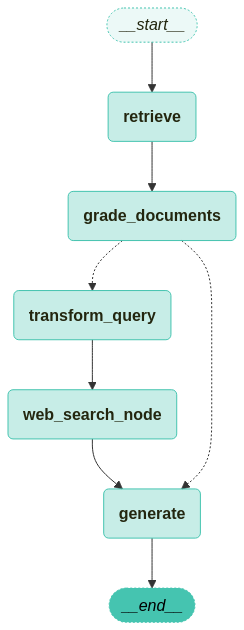

In [50]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)
